In [1]:
import proplot as pplt
import numpy as np
import xarray as xr
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import glob
import dask.array as da
from metpy.units import units
from scipy import stats
from scipy.stats import linregress

In [2]:
data_hist_ssp245_MPI_ESM  = '/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/MergeDataOut/tas_Amon_1850-2022_*.nc'

ds = xr.open_mfdataset(data_hist_ssp245_MPI_ESM, combine = 'nested', concat_dim = 'run')
ds

<xarray.Dataset>
Dimensions:    (time: 2076, run: 30, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    height     float64 2.0
Dimensions without coordinates: run, bnds
Data variables:
    time_bnds  (run, time, bnds) datetime64[ns] dask.array<chunksize=(1, 2076, 2), meta=np.ndarray>
    tas        (run, time, lat, lon) float32 dask.array<chunksize=(1, 2076, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.3 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/6b679cba-17b8-45eb-90dc-23d170c1998c
    CDO:                    Climate Data Operators version 2.0.3 (https://mpi...

In [3]:
type(ds)
ds['tas']
tas_transposed = ds['tas'].transpose('time','run','lat','lon')
tas_transposed

<xarray.DataArray 'tas' (time: 2076, run: 30, lat: 90, lon: 180)>
dask.array<transpose, shape=(2076, 30, 90, 180), dtype=float32, chunksize=(2076, 1, 90, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
    height   float64 2.0
Dimensions without coordinates: run
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    units:          K
    comment:        near-surface (usually, 2 meter) air temperature
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-09-11T14:13:17Z altered by CMOR: Treated scalar dime...

In [4]:
#Perfrom land sea mask
land_sea_mask=xr.open_dataset('/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/GR15_lsm_regrid.nc')
# land_sea_mask.coords
display(land_sea_mask)
# land_sea_mask.coords

<xarray.Dataset>
Dimensions:  (time: 1, lon: 180, lat: 90)
Coordinates:
  * time     (time) float64 201.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    var1     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.0
    history:      Sun May 14 21:24:57 2023: cdo remapbil,r180x90 /pool/data/M...
    CDO:          Climate Data Operators version 2.0.6 (https://mpimet.mpg.de...

In [5]:
mask_data = land_sea_mask['var1']
mask_data
# Align the time coordinates between the mask dataset and the original dataset
time_values = pd.to_datetime(mask_data['time'].values, format='mixed', dayfirst=True)
mask_data['time'] = time_values

# Align the time coordinates between the mask dataset and the original dataset
mask_data = mask_data.reindex(time=ds['time'], method='nearest')

# Apply the land-sea mask to the original dataset
masked_tas = ds.where(mask_data == 1, drop=False)

# # Broadcast the mask to match the shape of the original dataset's time dimension
# broadcasted_mask = xr.broadcast(mask_data, ds['time'])[0]

# # Apply the land-sea mask to the original dataset
# masked_tas = xr.where(broadcasted_mask == 1, ds, np.nan).fillna(np.nan)

# Print the resulting masked dataset
masked_tas

<xarray.Dataset>
Dimensions:    (run: 30, time: 2076, bnds: 2, lat: 90, lon: 180)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    height     float64 2.0
Dimensions without coordinates: run, bnds
Data variables:
    time_bnds  (run, time, bnds, lat, lon) datetime64[ns] dask.array<chunksize=(1, 2076, 2, 90, 180), meta=np.ndarray>
    tas        (run, time, lat, lon) float32 dask.array<chunksize=(1, 2076, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.3 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/6b679cba-17b8-45eb-90dc-23d170c1998c
    CDO:                    Climate Data Operators version 2.0.3 (https://mpi...

In [6]:
tas = masked_tas['tas'].loc[:,'1900-01-01':'2022-12-31',:,:]
tas = tas - 273.15
tas_climatology = tas.groupby('time.month').mean(dim='time')
tas_ano = tas.groupby('time.month') - tas_climatology
lat = tas_ano['lat']
lon = tas_ano['lon']

tas_ano

/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 123 times more chunks
  return self.array[key]


<xarray.DataArray 'tas' (run: 30, time: 1476, lat: 90, lon: 180)>
dask.array<sub, shape=(30, 1476, 90, 180), dtype=float32, chunksize=(1, 1, 90, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: run

In [7]:
#Separate data into monthly and output as new nc file
time_data = tas_ano['time']
time_index = pd.to_datetime(time_data.values)
time_index

DatetimeIndex(['1900-01-16 12:00:00', '1900-02-15 00:00:00',
               '1900-03-16 12:00:00', '1900-04-16 00:00:00',
               '1900-05-16 12:00:00', '1900-06-16 00:00:00',
               '1900-07-16 12:00:00', '1900-08-16 12:00:00',
               '1900-09-16 00:00:00', '1900-10-16 12:00:00',
               ...
               '2022-03-16 12:00:00', '2022-04-16 00:00:00',
               '2022-05-16 12:00:00', '2022-06-16 00:00:00',
               '2022-07-16 12:00:00', '2022-08-16 12:00:00',
               '2022-09-16 00:00:00', '2022-10-16 12:00:00',
               '2022-11-16 00:00:00', '2022-12-16 12:00:00'],
              dtype='datetime64[ns]', length=1476, freq=None)

In [8]:
weights = np.cos(np.deg2rad(tas.lat))*xr.ones_like(tas['lon'])

In [9]:
#calculate the annual mean of the SAT
# weights = np.cos(np.deg2rad(tas_ano.lat))
# weights.name = "weights"
# weights

tas_ano_weighted = tas_ano.weighted(weights)
# display(tas_ano_weighted)
tas_ano_weighted_mean = tas_ano_weighted.mean(dim=['lat','lon'])
tas_ano_weighted_mean

<xarray.DataArray 'tas' (run: 30, time: 1476)>
dask.array<truediv, shape=(30, 1476), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-01-16T12:00:00 ... 2022-12-16T12:00:00
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: run

In [10]:
tas_ano_annual = tas_ano_weighted_mean.groupby('time.year').mean('time')
tas_ano_annual
# display(tas_ano_annual.min().values)
# tas_ano_annual.max().values

<xarray.DataArray 'tas' (run: 30, year: 123)>
dask.array<transpose, shape=(30, 123), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: run

In [11]:
seasons = ['JJA', 'DJF']
season_means = {}

for season in seasons:
    if season == 'JJA':
        months = [6,7,8]
    elif season == 'DJF':
        months =[12,1,2]
    
    season_months = tas_ano.sel(time=tas.time.dt.month.isin(months),lat=slice(0,90))
    
    # Calculate the seasonal mean SAT anomalies
    season_mean_anomalies = (season_months * weights).mean(dim=['lat', 'lon']) / weights.mean(dim=['lat', 'lon'])
    
    # Store the seasonal mean in the dictionary
    season_means[season] = season_mean_anomalies

# Access the multiyear JJA mean SAT anomalies
    
JJA_tas = season_means['JJA']
DJF_tas = season_means['DJF']

JJA_tas

<xarray.DataArray (run: 30, time: 369)>
dask.array<truediv, shape=(30, 369), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-06-16 ... 2022-08-16T12:00:00
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
    month    (time) int64 6 7 8 6 7 8 6 7 8 6 7 8 6 ... 6 7 8 6 7 8 6 7 8 6 7 8
Dimensions without coordinates: run

In [12]:
DJF_tas_mean = DJF_tas.groupby('time.year').mean(dim='time')
DJF_tas_mean

<xarray.DataArray (run: 30, year: 123)>
dask.array<transpose, shape=(30, 123), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: run

In [13]:
JJA_tas_mean = JJA_tas.groupby('time.year').mean(dim='time')
# JJA_tas_mean[0,:].values
JJA_tas_mean

<xarray.DataArray (run: 30, year: 123)>
dask.array<transpose, shape=(30, 123), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: run

In [14]:
window_size =15
rolled = tas_ano_annual.rolling(year=15, center=True).construct("window_size")
rolled[0,:,:]

<xarray.DataArray 'tas' (year: 123, window_size: 15)>
dask.array<getitem, shape=(123, 15), dtype=float64, chunksize=(15, 15), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: window_size

In [15]:
#mask 
nyears = 123
windows =109
k=0
mask = np.zeros((windows, nyears))
for i in range(windows):
    mask[i,k:k+15]=1
    k=k+1

In [16]:
mask[0],mask[1]

windows = xr.DataArray(np.arange(0,109,1), dims='windows')
year = xr.DataArray(np.arange(1900, 2023,1), dims='year')
new_dims = {'windows': windows, 'year': year}
mask = xr.DataArray(mask,dims=('windows','year'), coords=new_dims)
type(mask)
display(mask)

<xarray.DataArray (windows: 109, year: 123)>
array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 1.]])
Coordinates:
  * windows  (windows) int64 0 1 2 3 4 5 6 7 ... 101 102 103 104 105 106 107 108
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2018 2019 2020 2021 2022

In [17]:
tas_ano_annual= xr.DataArray(tas_ano_annual)
# display(tas_ano_annual)
# tas_ano_annual_reshaped = tas_ano_annual.broadcast_like(mask)
masked_annual_tas = mask*tas_ano_annual
masked_annual_tas

<xarray.DataArray (windows: 109, year: 123, run: 30)>
dask.array<multiply, shape=(109, 123, 30), dtype=float64, chunksize=(109, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * windows  (windows) int64 0 1 2 3 4 5 6 7 ... 101 102 103 104 105 106 107 108
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: run

In [18]:
masked_annual_tas.isel(run=0).values

array([[-0.62799022, -0.43115061, -0.48028438, ...,  0.        ,
         0.        ,  0.        ],
       [-0.        , -0.43115061, -0.48028438, ...,  0.        ,
         0.        ,  0.        ],
       [-0.        , -0.        , -0.48028438, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.        , -0.        , -0.        , ...,  0.6403594 ,
         0.        ,  0.        ],
       [-0.        , -0.        , -0.        , ...,  0.6403594 ,
         1.19838389,  0.        ],
       [-0.        , -0.        , -0.        , ...,  0.6403594 ,
         1.19838389,  0.99475342]])

In [19]:
#the data should be the masked_annual_tas
#  dim is the selected run
#  trend is the returning running 15 year trend with the dimension size '101'
def polyfit_run(data):
    trend = np.zeros(109)
    for i in range(109):
        trend[i] = np.polyfit(range(15), data[i,:][data[i,:] != 0], deg=1)[0]
    return trend

In [20]:
window_size = 15

num_runs= 30
num_points  = 123
num_windows = num_points - window_size + 1 

trend = np.zeros((num_runs,num_windows))

for irun in range(30):
    trend[irun,:]=polyfit_run(masked_annual_tas.isel(run=irun).values)

In [21]:
trend

array([[ 0.01133186,  0.01762187,  0.02400232, ...,  0.00483754,
         0.00935914,  0.00842551],
       [ 0.00804587,  0.0142372 ,  0.02243579, ...,  0.01910093,
         0.02901849,  0.0360302 ],
       [-0.00986869, -0.00293161,  0.00556991, ...,  0.04425848,
         0.04536368,  0.03825937],
       ...,
       [-0.00800853, -0.00098517,  0.00601476, ...,  0.04711834,
         0.03646086,  0.0254013 ],
       [-0.00950344, -0.01076257, -0.00683585, ...,  0.04854585,
         0.06002068,  0.05407226],
       [ 0.0229744 ,  0.02610968,  0.03464502, ...,  0.04918048,
         0.04316739,  0.0378305 ]])

In [22]:
tas_ano_JJA= xr.DataArray(JJA_tas_mean)
display(tas_ano_JJA)
# tas_ano_annual_reshaped = tas_ano_annual.broadcast_like(mask)
masked_JJA_tas = mask*tas_ano_JJA
masked_JJA_tas

<xarray.DataArray (run: 30, year: 123)>
dask.array<transpose, shape=(30, 123), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: run

<xarray.DataArray (windows: 109, year: 123, run: 30)>
dask.array<multiply, shape=(109, 123, 30), dtype=float64, chunksize=(109, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * windows  (windows) int64 0 1 2 3 4 5 6 7 ... 101 102 103 104 105 106 107 108
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: run

In [23]:
tas_ano_DJF= xr.DataArray(DJF_tas_mean)
display(tas_ano_DJF)
# tas_ano_annual_reshaped = tas_ano_annual.broadcast_like(mask)
masked_DJF_tas = mask*tas_ano_DJF
masked_DJF_tas

<xarray.DataArray (run: 30, year: 123)>
dask.array<transpose, shape=(30, 123), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: run

<xarray.DataArray (windows: 109, year: 123, run: 30)>
dask.array<multiply, shape=(109, 123, 30), dtype=float64, chunksize=(109, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * windows  (windows) int64 0 1 2 3 4 5 6 7 ... 101 102 103 104 105 106 107 108
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: run

In [24]:
trend_JJA = np.zeros((num_runs,num_windows))

for irun in range(30):
    trend_JJA[irun,:]=polyfit_run(masked_JJA_tas.isel(run=irun).values)

In [25]:
trend_DJF = np.zeros((num_runs,num_windows))

for irun in range(30):
    trend_DJF[irun,:]=polyfit_run(masked_DJF_tas.isel(run=irun).values)

In [26]:
#Calculate the 15yr running trend time series
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
from sklearn.linear_model import LinearRegression

In [27]:
# tas_JJA_3dim = np.lib.stride_tricks.sliding_window_view(JJA_tas_mean,(1, window_size))

# trend_JJA = signal.detrend(tas_JJA_3dim, axis=1)
# slope_JJA = trend_JJA[:,:,-1]
# slope_JJA

In [28]:

# tas_DJF_3dim = np.lib.stride_tricks.sliding_window_view(DJF_tas_mean,(1, window_size))
# print(tas_DJF_3dim.shape)
# trend_DJF = signal.detrend(tas_DJF_3dim, axis=1)
# slope_DJF = trend_DJF[:,:,-1]
# slope_DJF

In [29]:
#output 30 run annual mean SAT
# tas_ano_annual_np = tas_ano_annual['tas'].values
x = np.arange(1900,2009,1)
num_time_series = tas_ano_annual.shape[0]

#calculate the ensemble mean of the MPI-ESM-LR 
tas_annual_mean = tas_ano_annual.mean('run')
# tas_annual_mean.values

In [30]:
year = xr.DataArray(np.arange(1900,2009,1),dims='year')
print(len(year))
trend_mean = trend.mean((0))
trend_JJA_mean = trend_JJA.mean((0))
trend_DJF_mean = trend_DJF.mean((0))

trend_DJF_mean.shape
trend_mean = xr.DataArray(trend_mean,dims=('year'), coords={'year': year})
trend_JJA_mean = xr.DataArray(trend_JJA_mean,dims=('year'), coords={'year': year})
trend_DJF_mean = xr.DataArray(trend_DJF_mean,dims=('year'), coords={'year': year})

109


In [31]:
#Input observational SAT timeseries
#Annual
CRUTEMP  = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/Data-output/CRUTEMP_annual_NH_15yr_trend.txt',delimiter='\t', skip_header=1)
CRUTEMP1 = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/Data-output/CRUTEMP_JJA_NH_15yr_trend.txt',delimiter='\t', skip_header=1)
CRUTEMP2 = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/Data-output/CRUTEMP_DJF_NH_15yr_trend.txt',delimiter='\t', skip_header=1)
CRUTEMP_annual = CRUTEMP[:,1]
CRUTEMP_JJA = CRUTEMP1[:,1]
CRUTEMP_DJF = CRUTEMP2[:,1]
# print(CRUTEMP_annual)
# print(CRUTEMP_JJA)
# print(CRUTEMP_DJF)

In [32]:
GISS = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/Data-output/GISS_annual_NH_15yr_trend.txt',delimiter='\t', skip_header=1)
GISS1 = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/Data-output/GISS_JJA_NH_15yr_trend.txt',delimiter='\t', skip_header=1)
GISS2 = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/Data-output/GISS_DJF_NH_15yr_trend.txt',delimiter='\t', skip_header=1)
GISS_annual = GISS[:,1]
GISS_JJA = GISS1[:,1]
GISS_DJF = GISS2[:,1]
# print(GISSTEMP_annual)
# print(GISSTEMP_JJA)
# print(GISSTEMP_DJF)

In [33]:
MLOST = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/Data-output/MLOST_annual_NH_15yr_trend.txt',delimiter='\t', skip_header=1)
MLOST1 = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/Data-output/MLOST_JJA_NH_15yr_trend.txt',delimiter='\t', skip_header=1)
MLOST2 = np.genfromtxt(fname='/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/Data-output/MLOST_DJF_NH_15yr_trend.txt',delimiter='\t', skip_header=1)
MLOST_annual = MLOST[:,1]
MLOST_JJA = MLOST1[:,1]
MLOST_DJF = MLOST2[:,1]
# print(MLOSTTEMP_annual)
# print(MLOSTTEMP_JJA)
print(MLOST_DJF.shape)

(109,)


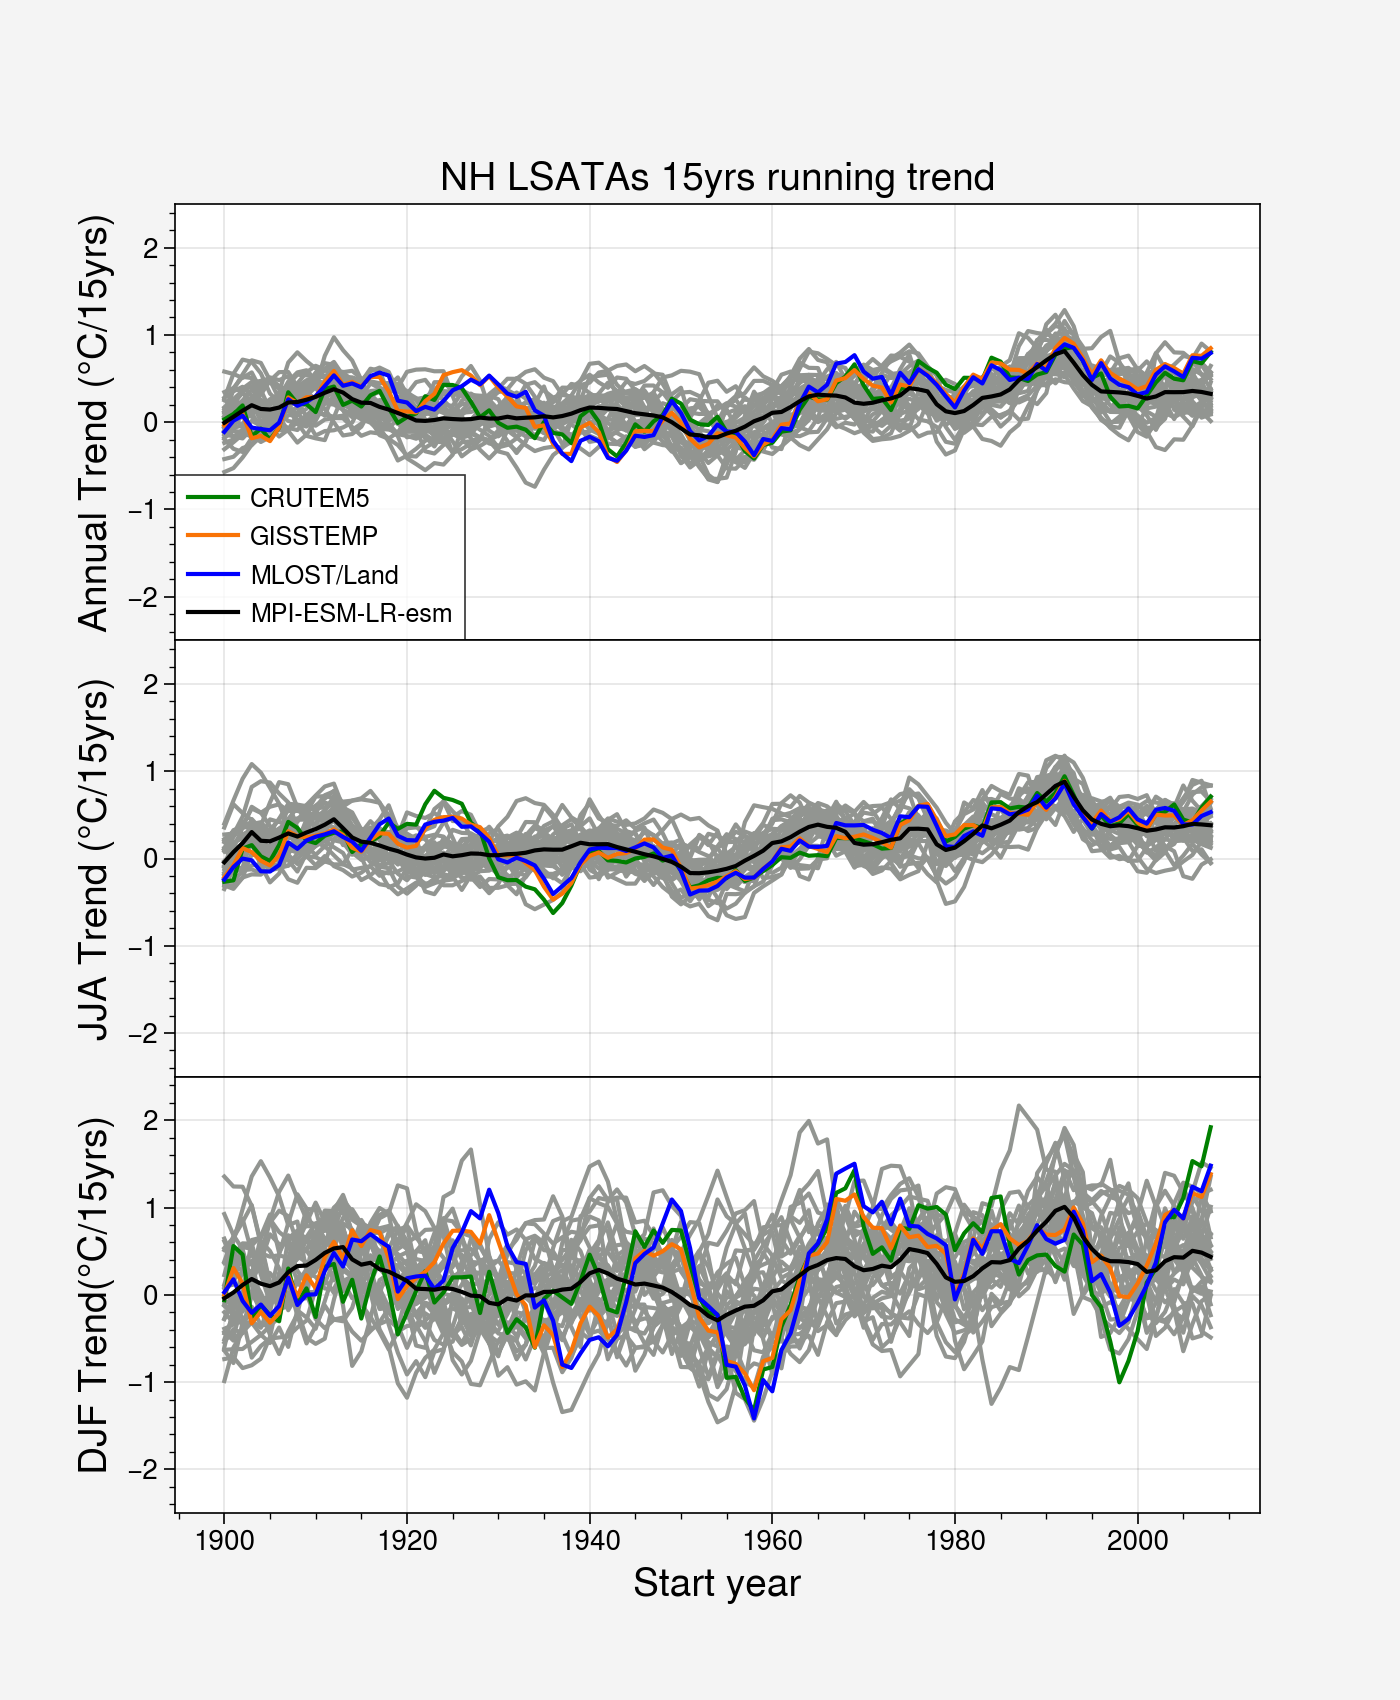

In [34]:
fig,axs = plt.subplots(3,1, figsize=(7,8.5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)

for i in range(num_time_series):
    axs[0].plot(x, trend[i, :]*15, color='gray')
    
axs[0].plot(x, CRUTEMP_annual*15, color='green', label='CRUTEM5')
axs[0].plot(x, GISS_annual*15, color='orange', label='GISSTEMP')
axs[0].plot(x, MLOST_annual*15, color='blue', label='MLOST/Land')
axs[0].plot(x, trend_mean*15, color='black', label='MPI-ESM-LR-esm')
axs[0].set_title('NH LSATAs 15yrs running trend',fontsize=14)
axs[0].set_ylabel('Annual Trend (°C/15yrs)', fontsize=14)
axs[0].set_xlabel('Start year', fontsize=14)
axs[0].set(ylim=(-2.5,2.5))
# axs[0].grid(visible=False, which='major', axis='y')
axs[0].tick_params(axis='x', labelsize=10)
axs[0].tick_params(axis='y', labelsize=10)
axs[0].legend()
# Plot the JJA time series
for i in range(num_time_series):
    axs[1].plot(x, trend_JJA[i, :]*15, color='gray')

axs[1].plot(x, CRUTEMP_JJA*15, color='green')
axs[1].plot(x, GISS_JJA*15, color='orange')
axs[1].plot(x, MLOST_JJA*15, color='blue')
axs[1].plot(x, trend_JJA_mean*15, color='black')
axs[1].set_ylabel('JJA Trend (°C/15yrs)', fontsize=14)
axs[1].set_xlabel('Start year', fontsize=14)
# axs[1].grid(visible=False, which='major', axis='y')
axs[1].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='y', labelsize=10)

# Plot the DJF time series
for i in range(num_time_series):
    axs[2].plot(x, trend_DJF[i, :]*15, color='gray')
    
axs[2].plot(x, CRUTEMP_DJF*15, color='green')
axs[2].plot(x, GISS_DJF*15, color='orange')
axs[2].plot(x, MLOST_DJF*15, color='blue')
axs[2].plot(x, trend_DJF_mean*15, color='black')
# axs[2].set_title('MPI-ESM1-LR 1850-2014 DJF SAT')
axs[2].set_ylabel('DJF Trend(°C/15yrs)', fontsize=14)
axs[2].set_xlabel('Start year', fontsize=14)
# axs[2].grid(visible=False, which='major', axis='y')
axs[2].tick_params(axis='x', labelsize=10)
axs[2].tick_params(axis='y', labelsize=10)

plt.show()

In [35]:
fig.savefig("./MPI-ESM-LR-NH_SATAs_15yr_running_trend.png")

## Extract 2008-2022 Trend values

In [54]:
MLOST_DJF_trend = MLOST_DJF[-1]*15.0
MLOST_DJF_trend = np.round(MLOST_DJF_trend, decimals=2)
print(MLOST_DJF_trend)

MLOST_JJA_trend = MLOST_JJA[-1]*15.0
MLOST_JJA_trend = np.round(MLOST_JJA_trend, decimals=2)
print(MLOST_JJA_trend)


1.48
0.53


In [42]:
GISS_DJF_trend = GISS_DJF[-1]*15.0
GISS_DJF_trend = np.round(GISS_DJF_trend, decimals=2)
print(GISS_DJF_trend)

GISS_JJA_trend = GISS_JJA[-1]*15.0
GISS_JJA_trend = np.round(GISS_JJA_trend, decimals=2)
print(GISS_JJA_trend)

CRUTEMP_DJF_trend = CRUTEMP_DJF[-1]*15.0
CRUTEMP_DJF_trend = np.round(CRUTEMP_DJF_trend, decimals=2)
print(CRUTEMP_DJF_trend)

CRUTEMP_JJA_trend = CRUTEMP_JJA[-1]*15.0
CRUTEMP_JJA_trend = np.round(CRUTEMP_JJA_trend, decimals=2)
print(CRUTEMP_JJA_trend)

1.38
0.65
1.92
0.71


In [43]:
# extract 30 runs trend values
trend_30runs_annual = trend[:, -1]*15.0
trend_30runs_annual = np.round(trend_30runs_annual, decimals=2)
print(trend_30runs_annual)

[0.13 0.54 0.57 0.11 0.64 0.15 0.21 0.09 0.27 0.35 0.49 0.13 0.01 0.2
 0.28 0.54 0.18 0.46 0.31 0.38 0.09 0.53 0.29 0.37 0.23 0.26 0.15 0.38
 0.81 0.57]


In [50]:
# trend_30runs_JJA = trend_JJA[:, -1]*15.0
# trend_30runs_JJA = np.round(trend_30runs_JJA, decimals=2)
# print(trend_30runs_JJA)

# trend_30runs_DJF = trend_DJF[:, -1]*15.0
# trend_30runs_DJF = np.round(trend_30runs_DJF, decimals=2)
# print(trend_30runs_DJF), print(trend_30runs_DJF.shape)

In [51]:
trend_30runs_DJF = pd.DataFrame({'run': np.arange(1,31,1), 'values': trend_DJF[:,-1]*15.0})
trend_30runs_DJF.to_csv('MPI-ESM-LR_NH_SATAs_15yr_DJF_trend.txt', sep='\t', index=False)


In [52]:
trend_30runs_JJA = pd.DataFrame({'run': np.arange(1,31,1), 'values': trend_JJA[:,-1]*15.0})
trend_30runs_JJA.to_csv('MPI-ESM-LR_NH_SATAs_15yr_JJA_trend.txt', sep='\t', index=False)

In [53]:
trend_30runs_annual = pd.DataFrame({'run': np.arange(1,31,1), 'values': trend[:,-1]*15.0})
trend_30runs_annual.to_csv('MPI-ESM-LR_NH_SATAs_15yr_annual_trend.txt', sep='\t', index=False)